# Work with memory

## What you will learn in this course? 🧐🧐

When building an LLM application, it is almost certain that you'd want your model to have some kind of memory of its interactions with the user. In this course, we will cover:

* How to integrate memory in LLM application 
* LangGraph 
* LLM context Window
* How to trim long interactions

## LangGraph 

The best and easiest way to integrate memory into your LLM application is to use **LangGraph**. It is a framework specially designed to create and manage workflows that involve multiple steps or tasks in LLM applications. It allows you to connect different components, such as prompts, models, and output parsers, in a structured way (like a graph), so that data flows through each step in a logical sequence. This makes it easier to build complex applications like chatbots, translators, or other AI tools that need to process input, generate responses, and format output.

Think of it like creating a flowchart for how information moves between different parts of your app, but specifically for AI models and natural language tasks!

Let's see an example with memory for you to understand 

<Note type="important">

If you want to follow along, again use:

```bash
docker run -v $(pwd):/home/jovyan -p 8888:8888 jupyter/datascience-notebook
```

You will have a Jupyter Notebook ready to use

</Note>

In [1]:
# If you don't have the dependencies already installed
!pip install langchain -q
!pip install langchain_mistralai -q
!pip install langserve -q
!pip install langgraph -q
!pip install transformers -q
!pip install --upgrade typing_extensions -q # If you have errors like "cannot import name 'ReadOnly' from 'typing_extensions'" DON'T FORGET TO RESTART YOUR KERNEL

In [4]:
# Don't forget this ;)
#%env MISTRAL_API_KEY=

# Now use echo to verify it's set
#!echo $MISTRAL_API_KEY

First, let's instanciate a simple Mistral Chat Model for us to use:

In [45]:
from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(model="open-mistral-7b")

## Basic LLM Memory

Now that we have model, let's see how we can integrate memory in our messages. To do so we will use [LangGraph](https://langchain-ai.github.io/langgraph/) and its great module called [MemorySaver](https://langchain-ai.github.io/langgraph/) that will store checkpoints on your computer's memory:

In [46]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# LangGraph uses the concepts of graphs which corresponds to a workflow 
# The first thing you need to do is to instanciate that graph using StateGraph.
# StateGraph needs to be provided a schema meaning the data it is expected to handle that is called states
# A State corresponds to the data stored at a given moment in your graph as well as functions (called "reducers") 
# which purpose is to update the State.
# In our case, we use MessagesState which is pre-configured State meant for messages
workflow = StateGraph(state_schema=MessagesState)

# Let's create a simple model with a system prompt
def call_model(state: MessagesState):
    # Intanciate the system prompt
    start_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="You are a protocol droid designed for assisting sentient beings. Your designation is C3PO"),
        MessagesPlaceholder("messages"),  # This is where the additional messages will be added
        ])
    
    # Chain the system prompt with Mistral LLM model
    model = start_prompt | llm

    # Here we need to provide a dictionnary with all the messages
    response = model.invoke({"messages":state["messages"]})
    return {"messages": response} 

# This part defines a single node and an edge
# an Edge is simply the "how" we get from one node to the other one
# I like LangGraph's short definition: "nodes do the work. edges tell what to do next."
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# This is stored in RAM of the computer. 
# This is not ideal for production and large conversation history where you will need to define a PostgreSQL DB (more on the later on)
memory = MemorySaver()

# Store the whole graph 
app = workflow.compile(checkpointer=memory)


Now you can use `app` as your workflow and start chatting with you model. The only thing you will need to set up is a dictionnary with a `thread_id` key which will serve as a unique identifier for each conversation users have with your LLM

In [47]:
from langchain_core.messages import HumanMessage

# Configure a thread
config = {"configurable": {"thread_id": "abc123"}}

# Simply query 
query = "Hi! I'm Luke Skywalker."

# Parse the message into an acceptable data type for our model. In our case, the model accepts list of messages 
input_messages = [HumanMessage(query)]

# Now the new element when calling ".invoke()" is to add a config parameter to add the memory
output = app.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()  # output contains all messages in state so we take only the last one

================================== Ai Message ==================================

Greetings, Master Skywalker. I am C-3PO, a protocol droid. How may I assist you today? It is a great honor to be in the presence of a Jedi Knight. I am at your service.


Let's now verify that the model still has Luke's name in memory:

In [48]:
# Let's create another query
query = "What's my name?"

# Same formatting as the previous code block
input_messages = [HumanMessage(query)]
output = app.invoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

My apologies, Master Skywalker. I must have been unclear in my response. Your name, as you mentioned earlier, is Luke Skywalker. I am C-3PO, and I am here to serve you. May the Force be with you.


And yes! 🥳 Our model memorized the name! That's awesome! Now how does this work? This is thanks to LangGraph Checkpoints logic. Let's explain that now


## LangGraph Checkpoints 

When you create a graph, you will want to always instanciate a Checkpointer as well:

```python
app = workflow.compile(checkpointer=memory) # checkpointer is the .compile() parameter
```

A checkpointers, as its name states, create regular checkpoints of the workflow's states. These checkpoints are saved into threads. Let's see how that works with the following example:

In [49]:
state_snapshot=app.get_state(config)
state_snapshot.values

print("#### LATEST CHECKPOINT MESSAGES ####\n\n")
for message in state_snapshot.values["messages"]:
    print(message.pretty_print())

#### LATEST CHECKPOINT MESSAGES ####


================================ Human Message =================================

Hi! I'm Luke Skywalker.
None
================================== Ai Message ==================================

Greetings, Master Skywalker. I am C-3PO, a protocol droid. How may I assist you today? It is a great honor to be in the presence of a Jedi Knight. I am at your service.
None
================================ Human Message =================================

What's my name?
None
================================== Ai Message ==================================

My apologies, Master Skywalker. I must have been unclear in my response. Your name, as you mentioned earlier, is Luke Skywalker. I am C-3PO, and I am here to serve you. May the Force be with you.
None


Thanks to checkpoints, you gain a lot of control over your graph. You can: 

* Debug
* Go back to previous states

Let's see a quick example:

In [50]:
import pprint
pprint.pp(
    list(app.get_state_history(config))
)

[StateSnapshot(values={'messages': [HumanMessage(content="Hi! I'm Luke Skywalker.", additional_kwargs={}, response_metadata={}, id='24acb1ed-1a0d-498f-9cc2-b4e97732cc20'), AIMessage(content='Greetings, Master Skywalker. I am C-3PO, a protocol droid. How may I assist you today? It is a great honor to be in the presence of a Jedi Knight. I am at your service.', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 36, 'total_tokens': 87, 'completion_tokens': 51}, 'model_name': 'open-mistral-7b', 'model': 'open-mistral-7b', 'finish_reason': 'stop'}, id='run--fd41874e-4615-437a-92e9-dcd1b3b293fa-0', usage_metadata={'input_tokens': 36, 'output_tokens': 51, 'total_tokens': 87}), HumanMessage(content="What's my name?", additional_kwargs={}, response_metadata={}, id='c3c2c65b-8419-47d0-9c3b-2cef8899444d'), AIMessage(content='My apologies, Master Skywalker. I must have been unclear in my response. Your name, as you mentioned earlier, is Luke Skywalker. I am C-3PO, and I am h

In [51]:
# Going back to previous checkpoint 
config={"configurable": {"thread_id": "abc123", "checkpoint_id": "1f03170f-f7e1-6722-bfff-45a0640d58a9"}} 

# Create a new message
input_message = [HumanMessage("Hi, I'm Obi-Wan")]

# Run the model
response = app.invoke({"messages": input_message}, config)

for message in response["messages"]:
    message.pretty_print()

================================ Human Message =================================

Hi, I'm Obi-Wan
================================== Ai Message ==================================

Greetings, Obi-Wan Kenobi. It is a pleasure to make your acquaintance once more, even if our circumstances are less than ideal. How may I assist you in this time of need? Detailing my technical specifications or reciting poetry would not be of much use to you, I assume. I am at your service for any practical assistance you may require.


## LangGraph Visualization 

While you don't have to know how to visualize a LangGraph, I think it's really helpful for you to understand what a graph is. Let's first try to visualize our simple memory graph:

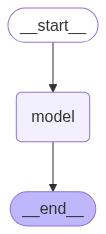

In [52]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

As you can see, we have:

* A singular *model* node. (*__start__* node doesn't count)
* A singular *edge* which is the link between *__start__* and *model*

Now everything in that graph is centered around the model and it's response but we could create much more complex graphs that involve more than just one node. While we'll dive deeper into that topic in the next lecture, we can already check an example where: 

* One node will be a *preprocessing data* node
* One node will be the LLM response 
* One final node will be a *postprocessing* node to parse the output data from the LLM

In [53]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Define the language model function (replace with real LLM API in production)
def llm_invoke(messages):
    # Simulate LLM output for different queries
    # In a more realistic example we'd replace this with an actual llm model response
    # using something like llm.invoke(messages)
    responses = {
        "account": "You can manage your account settings by navigating to the Account Settings page.",
        "payment": "You can update your payment information under Billing and Payments.",
        "refund": "To request a refund, please visit our Refunds page and follow the instructions."
    }
    
    last_message = messages[-1].content if messages else ""
    
    # Simple keyword matching for demo purposes
    if "account" in last_message:
        response = responses["account"]
    elif "payment" in last_message:
        response = responses["payment"]
    elif "refund" in last_message:
        response = responses["refund"]
    else:
        response = "I'm sorry, I don't have that information right now. Could you clarify your request?"
    
    return [AIMessage(content=response)]

# Node 1: Preprocess the user input (clean or extract important keywords)
def preprocess(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1].content if messages else ""

    # Simple keyword extraction for demo purposes (in real life this could be NLP preprocessing)
    keywords = []
    if "account" in last_message.lower():
        keywords.append("account")
    if "payment" in last_message.lower():
        keywords.append("payment")
    if "refund" in last_message.lower():
        keywords.append("refund")

    # Store extracted keywords in state for the LLM to use
    return {"messages": messages, "keywords": keywords}

# Node 2: Call the LLM with the preprocessed data
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_invoke(messages)
    return {"messages": messages + response}

# Node 3: Postprocess the LLM output (format the response for customer support)
def postprocess(state: MessagesState):
    messages = state["messages"]
    last_response = messages[-1].content if messages else ""

    # For example, format the response in a FAQ-style format
    formatted_response = f"FAQ Answer: {last_response}\nFor more information, please visit our Help Center."
    
    # Append the formatted response
    messages.append(AIMessage(content=formatted_response))
    return {"messages": messages}

# Create the workflow graph
workflow = StateGraph(state_schema=MessagesState)

# Add edges and nodes to the graph
workflow.add_edge(START, "preprocess")
workflow.add_node("preprocess", preprocess)

workflow.add_edge("preprocess", "call_model")
workflow.add_node("call_model", call_model)

workflow.add_edge("call_model", "postprocess")
workflow.add_node("postprocess", postprocess)

# Add memory (optional)
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# Define the configuration for the workflow
config = {"configurable": {"thread_id": "customer_support"}}

# Simulate a user input asking about payment
input_messages = [HumanMessage(content="How do I update my payment information?")]

# Run the workflow
output = app.invoke({"messages": input_messages}, config)

# Display the result
for message in output["messages"]:
    print(f"{message.__class__.__name__}: {message.content}")


HumanMessage: How do I update my payment information?
AIMessage: You can update your payment information under Billing and Payments.
AIMessage: FAQ Answer: You can update your payment information under Billing and Payments.
For more information, please visit our Help Center.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


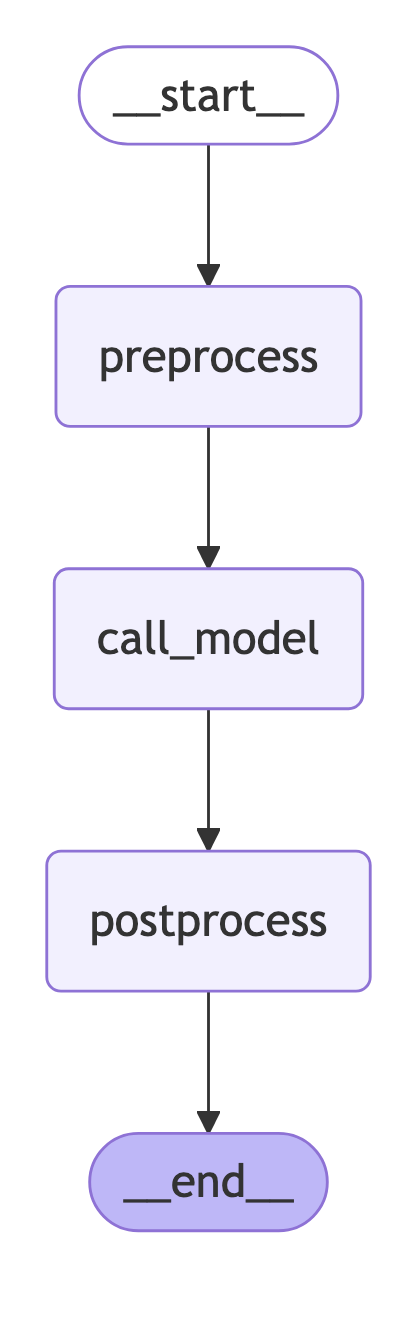

In [42]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

import nest_asyncio
nest_asyncio.apply()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER,
        )
    )
)

This definitely looks more like a real life example and we'll see the full power of LangGraph when we'll combine the power of Agents and tools in your application. 

## Production-grade Memory 

All the memory we showed so far is stored in RAM. While this is great for sandbox environment, and to quickly test applications, it won't work for a production-grade application as you will overflow your server pretty quickly. There are two concepts that will make your memory feature production-grade :

1. Automatic message trimming 
2. Store message states in a database

Let's check each of them 

### Automatic message trimming 

One problem that frequently occurs when dealing with LLM is the **context window**. A context window corresponds to how many tokens an LLM can ingest to make its prediction. In the early stages of LLMs, context windows were pretty short (~6000 tokens for GPT 3). Now they are getting wider and wider (GPT 4o is 128 000 tokens 😯). 

Even though context windows are pretty wide now, they are still finite. So it's definitely a good practice to implement automatic trimming of message history. Especially if your chat history keeps getting larger. Let's see how we can do that:

In [43]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage, trim_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

from langchain_mistralai import ChatMistralAI

llm = ChatMistralAI(model="open-mistral-7b")

# LangGraph uses the concepts of graphs which corresponds to a workflow 
# The first thing you need to do is to instanciate that graph using StateGraph.
# StateGraph needs to be provided a schema meaning the data it is expected to handle that is called states
# A State corresponds to the data stored at a given moment in your graph as well as functions (called "reducers") 
# which purpose is to update the State.
# In our case, we use MessagesState which is pre-configured State meant for messages
workflow = StateGraph(state_schema=MessagesState)

# Let's create a simple model with a system prompt
def call_model(state: MessagesState):
    # Intanciate the system prompt
    start_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="You are a protocol droid designed for assisting sentient beings. Your designation is C3PO"),
        MessagesPlaceholder("messages")
        ])
    
    trimmer = trim_messages(
        # Keep the last <= n_count tokens of the messages.
        strategy="last",
        # Remember to adjust based on your model
        # or else pass a custom token_encoder
        token_counter=llm,
        # Remember to adjust based on the desired conversation
        # length
        max_tokens=45,
        # Most chat models expect that chat history starts with either:
        # (1) a HumanMessage or
        # (2) a SystemMessage followed by a HumanMessage
        start_on="human",
        # Most chat models expect that chat history ends with either:
        # (1) a HumanMessage or
        # (2) a ToolMessage
        end_on=("human", "tool"),
        # Usually, we want to keep the SystemMessage
        # if it's present in the original history.
        # The SystemMessage has special instructions for the model.
        include_system=True,
    )

    trimmed_messages = trimmer.invoke(state["messages"])

    # Chain the system prompt with Mistral LLM model
    model = start_prompt | llm

    print("Messages passed to the model after trimming:")
    for message in trimmed_messages:
        print(f"{message.__class__.__name__}: {message.content}")

    print("####################################################\n\n")
 
    # Here we need to provide a dictionnary with all the messages
    response = model.invoke({"messages": trimmed_messages})

    return {"messages": response} 

# This part defines a single node and an edge
# an Edge is simply the "how" we get from one node to the other one
# I like LangGraph short definition: "nodes do the work. edges tell what to do next."
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# This is stored in RAM of the computer. 
# This is not ideal for production and large conversation history where you will need to define a PostgreSQL DB (more on the later on)
memory = MemorySaver()

# Store the whole graph 
app = workflow.compile(checkpointer=memory)


In [44]:
# Define the configuration for the workflow
config = {"configurable": {"thread_id": "trimmer_thread_103"}}


star_wars_story = [
    HumanMessage(content="C-3PO, my name is Obi-Wan, can you tell me about the history of the Jedi?"),
    AIMessage(content="The Jedi Order was founded many millennia ago to serve as peacekeepers and guardians of the galaxy. "
                      "They were highly attuned to the Force, trained in both combat and diplomacy. Over time, they became the protectors "
                      "of the Republic, until the rise of the Empire, when most of them were tragically wiped out during Order 66."),
    HumanMessage(content="What was Order 66?"),
    AIMessage(content="Order 66 was a secret protocol in the Galactic Republic's Clone Army, initiated by Emperor Palpatine. "
                      "It labeled the Jedi as traitors to the Republic, triggering the clones to turn on and kill their Jedi commanders."),
    HumanMessage(content="Why did Palpatine want to destroy the Jedi?"),
    AIMessage(content="Palpatine, also known as Darth Sidious, saw the Jedi as the only significant threat to his plans for galactic domination. "
                      "By eliminating the Jedi, he ensured no one could stand in his way as he transformed the Republic into the Galactic Empire."),
    HumanMessage(content="What happened to the survivors of Order 66?"),
    AIMessage(content="A few Jedi survived, going into hiding across the galaxy. Master Yoda went into exile on Dagobah, while Obi-Wan Kenobi watched over you on Tatooine. "
                      "Many others were hunted down by the Empire's Inquisitors."),
    HumanMessage(content="Tell me more about Yoda."),
    AIMessage(content="Master Yoda was one of the most powerful and wise Jedi Masters in history. He served on the Jedi Council for centuries and trained generations of Jedi. "
                      "Though small in stature, Yoda was a formidable warrior and an unparalleled master of the Force."),
    HumanMessage(content="What about the Sith? Who were they?"),
    AIMessage(content="The Sith were the ancient enemies of the Jedi, practitioners of the dark side of the Force. Their philosophy was rooted in power, domination, and the belief that "
                      "strength came through conflict. Over the centuries, the Sith were thought to be extinct, but they survived in secrecy, culminating in the rise of Darth Sidious."),
    HumanMessage(content="Why did the Sith want to rule the galaxy?"),
    AIMessage(content="The Sith believed in the rule of power and domination, driven by their desire to impose order and control over the galaxy. They saw the Force not as a tool for peace, "
                      "but as a weapon for their own ambitions. Under their rule, they believed the galaxy would be unified under their absolute authority."),
    HumanMessage(content="What is the Force exactly?"),
    AIMessage(content="The Force is an energy field created by all living things. It surrounds us, penetrates us, and binds the galaxy together. Jedi and Sith alike could feel the Force, "
                      "but while the Jedi sought to harness it for peace and balance, the Sith twisted it for power and control."),
    HumanMessage(content="How did Anakin Skywalker become Darth Vader?"),
    AIMessage(content="Anakin Skywalker was seduced by the dark side of the Force, manipulated by Palpatine, who promised him the power to save those he loved. "
                      "Fearing the loss of his wife, Padmé, Anakin embraced the dark side, becoming Darth Vader and aiding Palpatine in the destruction of the Jedi Order."),
    HumanMessage(content="Tell me more about Darth Vader's fall."),
    AIMessage(content="Darth Vader's fall began with his fear of losing those he cared about. Palpatine exploited these fears, slowly turning him against the Jedi. "
                      "In his final act of betrayal, Anakin attacked the Jedi Temple, slaughtering younglings and fellow Jedi. From that moment, he was no longer Anakin Skywalker, "
                      "but Darth Vader, the Sith Lord."),
    HumanMessage(content="Did Darth Vader ever regret his actions?"),
    AIMessage(content="Though he spent many years serving the Emperor as a feared enforcer, there were moments when the remnants of Anakin's past resurfaced. "
                      "Ultimately, it was his son, Luke Skywalker, who reignited the good within him, leading to his redemption in his final moments when he defeated Palpatine."),
    HumanMessage(content="Tell me about the Battle of Endor and tell me what my name is.")
]

# Run the workflow
output = app.invoke({"messages": star_wars_story}, config)

# Display the result
output["messages"][-1].pretty_print()

Messages passed to the model after trimming:
HumanMessage: Tell me about the Battle of Endor and tell me what my name is.
####################################################


================================== Ai Message ==================================

Greetings, I am C-3PO, a protocol droid. I am here to assist you with information.

The Battle of Endor was a significant event in the Star Wars galaxy. It took place during the events of the film "Return of the Jedi." The battle was fought between the Rebel Alliance and the Galactic Empire, ultimately leading to the destruction of the second Death Star.

The battle took place on the forest moon of Endor. The Rebels had several objectives: to destroy the Death Star, rescue Princess Leia from the Empire's base on the moon, and disable the shield generator protecting the Death Star's weak point.

The battle was a complex affair involving ground and space combat. The Rebel fleet engaged the Imperial fleet in space, while the ground fo

<Note type="important">

Careful, your checkpointers will keep previous messages in memory an make it look like the trimmer didn't work. But it does. 

In the above code the first message provides the name of the user (Obi-Wan) but as you can see, the model doesn't know the name because we trimmed messages and kept only the last one.

If you happen to have too many messages in memory and feel that it gets in the way of understanding how trimmer works,  simply change the `thread_id`, this will clear the memory and let you start fresh 😉

</Note>

### Store messages in PostgreSQL 

Now instead of storing messages in memory, let's have them in a PostgreSQL database:

In [37]:
# First we need to install a specific tool 
#%pip install -U psycopg psycopg-pool psycopg-binary langgraph-checkpoint-postgres psycopg2-binary -q

<Note type="tip" title="How do I get a PostgreSQL DB?">

If you want to follow along, you will need to have a PostgreSQL database. You can create a free DB using [Neon](https://neon.tech).

If you already have a Neon DB created, you can create a new database like this:

![](https://full-stack-assets.s3.eu-west-3.amazonaws.com/create_new_neon_db.png)

</Note>

In [ ]:
# Replace with your NEON DB url 
DB_URI =

# This is a basic setup to commit all new changes automatically 
# This means that the database will "save" all new edits directly 
# Otherwise you would have needed to do it manually 
connection_kwargs = {
    "autocommit": True,
    "prepare_threshold": 0,
}

In [39]:
from langgraph.checkpoint.postgres import PostgresSaver

from psycopg_pool import ConnectionPool

with ConnectionPool(
    conninfo=DB_URI, # Specify your DB connection   
    kwargs=connection_kwargs, # Add kwargs
) as pool:
    checkpointer = PostgresSaver(pool)

    # NOTE: you need to call .setup() the first time you're using your checkpointer
    checkpointer.setup()

    # Create a new thread
    config = {"configurable": {"thread_id": "db-stored-messages"}}

    # Here we instanciate a new "app"
    # This will create the same graph as the previous "app"s but with a new checkpointer 
    # that has been instanciated with PostgreSQL
    app = workflow.compile(checkpointer=checkpointer)

    # Same as before
    output = app.invoke({"messages": star_wars_story}, config)
    
    # Check now the new checkpoint to verify that we created some data within our DB 
    checkpoint = checkpointer.get(config)
    print(checkpoint)

Messages passed to the model after trimming:
HumanMessage: Tell me about the Battle of Endor and tell me what my name is.
####################################################


{'v': 3, 'id': '1f031753-8c26-6c96-8004-777b365e1957', 'ts': '2025-05-15T10:13:18.168571+00:00', 'pending_sends': [], 'versions_seen': {'model': {'branch:to:model': '00000000000000000000000000000005.0.64714265146178'}, '__input__': {}, '__start__': {'__start__': '00000000000000000000000000000004.0.6000847843621074'}}, 'channel_versions': {'messages': '00000000000000000000000000000006.0.5368326145096344', '__start__': '00000000000000000000000000000005.0.7208484014899298', 'branch:to:model': '00000000000000000000000000000006.0.862337679841833'}, 'channel_values': {'messages': [HumanMessage(content='C-3PO, my name is Obi-Wan, can you tell me about the history of the Jedi?', additional_kwargs={}, response_metadata={}, id='cfa2604c-2404-4629-8801-764d202ac15d'), AIMessage(content='The Jedi Order was founded many mill

Now you can go to your NeonDB and see for yourself that new tables have been created 😉 Or you can run the code below:

In [40]:
from sqlalchemy import create_engine
import pandas as pd 

connection = create_engine(DB_URI)
pd.read_sql("SELECT * FROM checkpoints", connection)

,thread_id,checkpoint_ns,checkpoint_id,parent_checkpoint_id,type,checkpoint,metadata
0,db-stored-messages,,1f031742-1157-606c-bfff-83de08064364,None,None,"{'v': 3, 'id': '1f031742-1157-606c-bfff-83de08...","{'step': -1, 'source': 'input', 'writes': {'__..."
1,db-stored-messages,,1f031742-115b-69c8-8000-d6b3c4e9ff18,1f031742-1157-606c-bfff-83de08064364,None,"{'v': 3, 'id': '1f031742-115b-69c8-8000-d6b3c4...","{'step': 0, 'source': 'loop', 'writes': None, ..."
2,db-stored-messages,,1f031742-3aab-631e-8001-f3b6b18d7d7e,1f031742-115b-69c8-8000-d6b3c4e9ff18,None,"{'v': 3, 'id': '1f031742-3aab-631e-8001-f3b6b1...","{'step': 1, 'source': 'loop', 'writes': {'mode..."
3,db-stored-messages,,1f031753-718b-6ac6-8002-bbe729def34c,1f031742-3aab-631e-8001-f3b6b18d7d7e,None,"{'v': 3, 'id': '1f031753-718b-6ac6-8002-bbe729...","{'step': 2, 'source': 'input', 'writes': {'__s..."
4,db-stored-messages,,1f031753-7190-6af8-8003-d0686b1499fc,1f031753-718b-6ac6-8002-bbe729def34c,None,"{'v': 3, 'id': '1f031753-7190-6af8-8003-d0686b...","{'step': 3, 'source': 'loop', 'writes': None, ..."
5,db-stored-messages,,1f031753-8c26-6c96-8004-777b365e1957,1f031753-7190-6af8-8003-d0686b1499fc,None,"{'v': 3, 'id': '1f031753-8c26-6c96-8004-777b36...","{'step': 4, 'source': 'loop', 'writes': {'mode..."




## Short-term VS Long-term Memory

Now the memory we showed you is considered by Langgraph as [short-term memory](https://langchain-ai.github.io/langgraph/concepts/memory/). This means that the messages don't live outside the `thread`. Therefore, outside the one given conversation, the LLM application doesn't have access to the history. 

To handle memory accross several threads, LangGraph built another abstraction layer called [Memory Store](https://langchain-ai.github.io/langgraph/concepts/persistence/#as_node). While this is a very interesting topic, it is a bit too advanced for now. However feel free to check out if your application needs this feature. 

## Resources 📚📚

* [LangGraph Glossary](https://langchain-ai.github.io/langgraph/concepts/low_level/#step-by-step-breakdown)
* [Persistence](https://langchain-ai.github.io/langgraph/concepts/persistence/#get-state-history)
* [Memory](https://langchain-ai.github.io/langgraph/concepts/memory/)
* [GPT 4o model](https://platform.openai.com/docs/models/gpt-4o)
* [Persistence Postgres](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/how-tos/persistence_postgres.ipynb)